In [2]:
import torch, os, sys
print("torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pathlib import Path

torch: 2.5.1+cu121
CUDA: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
BASE = Path(".").resolve()
DATA_SPLIT = BASE / "dataset_split"
assert (DATA_SPLIT / "train").exists()
assert (DATA_SPLIT / "val").exists()

classes = sorted([d.name for d in (DATA_SPLIT / "train").iterdir() if d.is_dir()])
print("Classes:", classes)

Classes: ['Plastic', 'Wooden']


In [63]:
from collections import defaultdict
def count_images(split_dir: Path):
    cnt = defaultdict(int)
    for c in classes:
        p = split_dir / c
        if p.exists():
            for f in p.rglob("*"):
                if f.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}:
                    cnt[c] += 1
    return dict(cnt)

for sp in ["train", "val", "test"]:
    c = count_images(DATA_SPLIT / sp)
    print(sp, c, "total =", sum(c.values()))

train {'Plastic': 84, 'Wooden': 84} total = 168
val {'Plastic': 10, 'Wooden': 10} total = 20
test {'Plastic': 11, 'Wooden': 11} total = 22


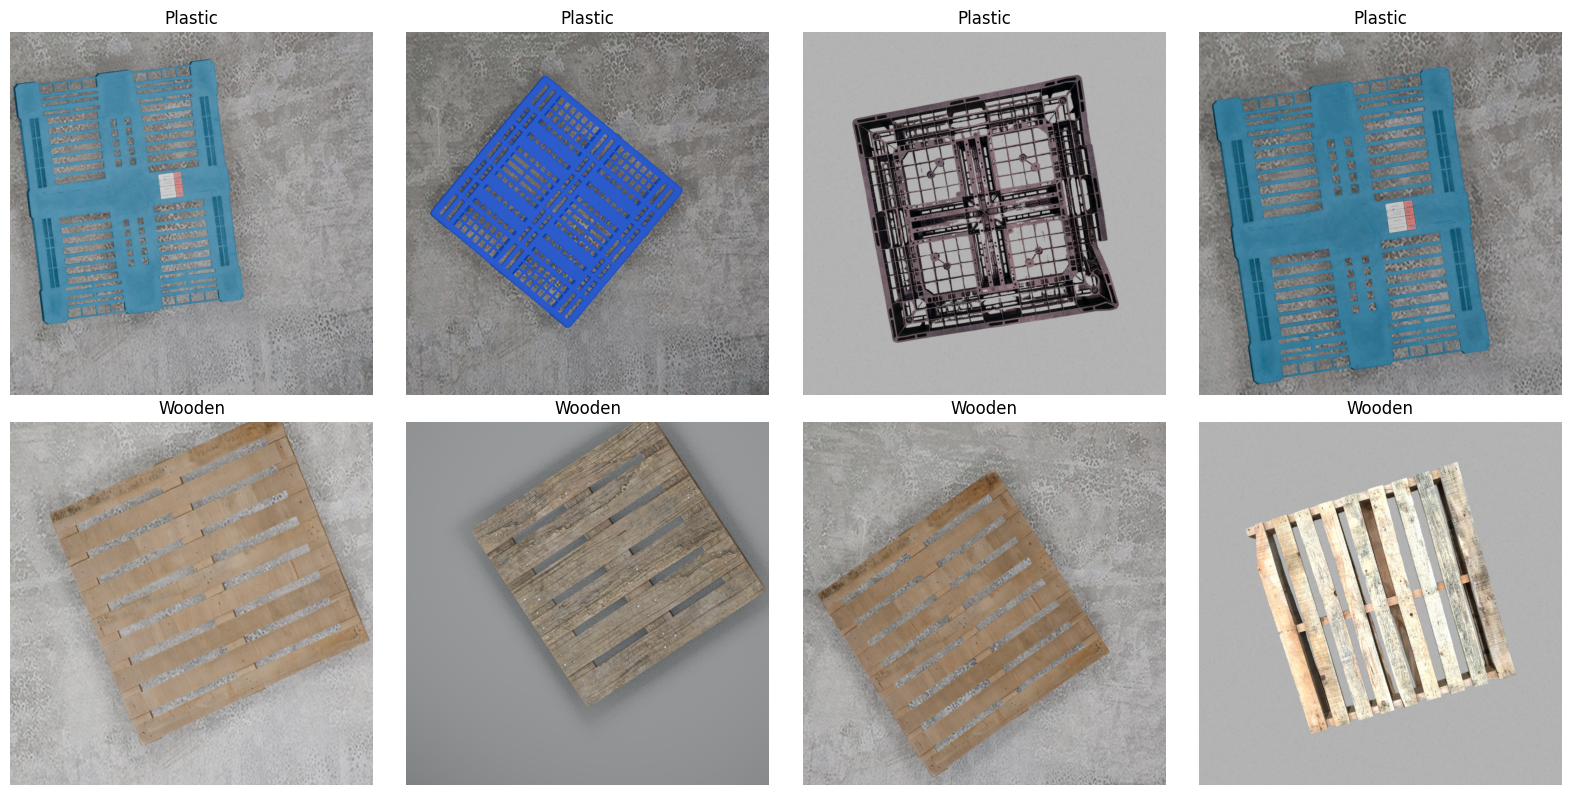

In [64]:
import random
from PIL import Image

def show_samples(split="train", n=8):
    imgs = []
    for c in classes:
        paths = list((DATA_SPLIT/split/c).rglob("*"))
        paths = [p for p in paths if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
        random.shuffle(paths)
        imgs += paths[:max(1, n//len(classes))]
    cols = min(4, len(imgs))
    rows = (len(imgs)+cols-1)//cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i, p in enumerate(imgs, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(Image.open(p))
        plt.title(f"{p.parent.name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples("train", n=8)


In [65]:
# สร้างโมเดลจากน้ำหนัก pretrain
model = YOLO("yolov8n-cls.pt")  # ขนาดเล็ก เทรนไว

results = model.train(
    data=str(DATA_SPLIT),  # โฟลเดอร์ที่มี train/ val/
    epochs=30,             # ปรับได้ 30-100 ตามเวลา/ทรัพยากร
    imgsz=224,             # ขนาดภาพสำหรับคลาสสิฟาย
    batch=-1,              # ให้ auto เลือกตาม VRAM; หรือกำหนดเช่น 32
    patience=10,           # early stop ถ้าไม่ดีขึ้น
    seed=42,
    project="runs/classify",
    name="pallet_v1",
    verbose=True
)


New https://pypi.org/project/ultralytics/8.3.185 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.183  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\ClassifyModel\dataset_split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pallet_v1, nbs=64, nms=Fal

AMP: checks passed 
AutoBatch: Computing optimal batch size for imgsz=224 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU) 8.00G total, 0.11G reserved, 0.06G allocated, 7.83G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     1440850      0.4115         0.107         17.61         247.6        (1, 3, 224, 224)                  (1, 2)
     1440850       0.823         0.141         7.385          39.6        (2, 3, 224, 224)                  (2, 2)
     1440850       1.646         0.151         11.31         34.07        (4, 3, 224, 224)                  (4, 2)
     1440850       3.292         0.182         11.62          38.8        (8, 3, 224, 224)                  (8, 2)
     1440850       6.584         0.245         12.71         36.48       (16, 3, 224, 224)                 (16, 2)
AutoBatch: Using batch-size 579 for CUDA:0 5.16G/8.00G (65%) 
train: Fast image access  (p

train: Scanning D:\ClassifyModel\dataset_split\train... 168 images, 0 corrupt: 100%|██████████| 168/168 [00:00<00:00, 329.21it/s]

train: New cache created: D:\ClassifyModel\dataset_split\train.cache


val: Fast image access  (ping: 0.20.1 ms, read: 178.976.9 MB/s, size: 1374.3 KB)


val: Scanning D:\ClassifyModel\dataset_split\val... 20 images, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 231.25it/s]

val: New cache created: D:\ClassifyModel\dataset_split\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0045234375), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\classify\pallet_v1
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]

                   all       0.55          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 84.87it/s]

                   all        0.5          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 85.85it/s]

                   all        0.5          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 96.42it/s]

                   all        0.6          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 86.19it/s]

                   all        0.6          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 81.51it/s]

                   all       0.65          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 109.00it/s]

                   all       0.65          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 75.43it/s]

                   all       0.75          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 86.40it/s]

                   all       0.85          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30      1.82G     0.4859        168        224: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 63.23it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30      1.82G     0.4693        168        224: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 71.29it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30      1.82G     0.3988        168        224: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 104.65it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30      1.82G     0.3562        168        224: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 82.19it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30      1.82G     0.3108        168        224: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 76.73it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30      1.82G     0.2938        168        224: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 67.04it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30      1.82G     0.2496        168        224: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 90.53it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30      1.82G     0.2231        168        224: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 110.95it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30      1.82G     0.2034        168        224: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 107.91it/s]

                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size



      19/30      1.82G      0.173        168        224: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 112.94it/s]

                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size



      20/30      1.82G     0.1587        168        224: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 73.35it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      21/30      1.82G     0.1449        168        224: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 85.58it/s]

                   all          1          1
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 11, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

21 epochs completed in 0.009 hours.


Optimizer stripped from runs\classify\pallet_v1\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\pallet_v1\weights\best.pt, 3.0MB

Validating runs\classify\pallet_v1\weights\best.pt...
Ultralytics 8.3.183  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: D:\ClassifyModel\dataset_split\train... found 168 images in 2 classes  
val: D:\ClassifyModel\dataset_split\val... found 20 images in 2 classes  
test: D:\ClassifyModel\dataset_split\test... found 22 images in 2 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 37.94it/s]


                   all          1          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\pallet_v1


In [66]:
# วัดผล (ค่า top1/top5 ฯลฯ) บนชุด val (ดีฟอลต์ของ train ทำไปแล้ว)
val_metrics = model.val(data=str(DATA_SPLIT))  # split= 'val' เป็นค่าเริ่มต้น
print("VAL metrics:", val_metrics.results_dict)

# วัดผลบนชุด test (ถ้ามี)
if (DATA_SPLIT / "test").exists():
    test_metrics = model.val(data=str(DATA_SPLIT), split="test")
    print("TEST metrics:", test_metrics.results_dict)


Ultralytics 8.3.183  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: D:\ClassifyModel\dataset_split\train... found 168 images in 2 classes  
val: D:\ClassifyModel\dataset_split\val... found 20 images in 2 classes  
test: D:\ClassifyModel\dataset_split\test... found 22 images in 2 classes  
val: Fast image access  (ping: 0.00.0 ms, read: 3484.11467.5 MB/s, size: 1374.3 KB)


val: Scanning D:\ClassifyModel\dataset_split\val... 20 images, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


                   all          1          1
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\pallet_v12
VAL metrics: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
Ultralytics 8.3.183  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
train: D:\ClassifyModel\dataset_split\train... found 168 images in 2 classes  
val: D:\ClassifyModel\dataset_split\val... found 20 images in 2 classes  
test: D:\ClassifyModel\dataset_split\test... found 22 images in 2 classes  
test: Fast image access  (ping: 0.30.4 ms, read: 178.034.4 MB/s, size: 1660.3 KB)


test: Scanning D:\ClassifyModel\dataset_split\test... 22 images, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 304.60it/s]

test: New cache created: D:\ClassifyModel\dataset_split\test.cache



               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


                   all          1          1
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\pallet_v13
TEST metrics: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}


In [67]:
print("Model class map:", model.names)  # ควรเป็น {0:'Plastic', 1:'Wooden'} ตามลำดับ

Model class map: {0: 'Plastic', 1: 'Wooden'}


In [74]:
BASE = Path(".").resolve()
SOURCE = BASE / "After_train_test_image"            # โฟลเดอร์รูปที่จะเทส
assert SOURCE.exists()

In [75]:
# เลือกน้ำหนัก: ใช้อันที่เทรนเสร็จก่อน ถ้าไม่เจอค่อยใช้ yolov8n-cls.pt
candidates = [
    BASE / "runs/classify/pallet_v1/weights/best.pt",  # แก้ชื่อรันตามของคุณ
    BASE / "runs/classify/weights/best.pt",
    BASE / "runs/classify/best.pt",
    BASE / "yolov8n-cls.pt",                           # pretrain
]

WEIGHTS = next((p for p in candidates if p.exists()), None)
assert WEIGHTS is not None

model = YOLO(str(WEIGHTS))
print("Model classes:", model.names)

Model classes: {0: 'Plastic', 1: 'Wooden'}


In [77]:
preds = model.predict(source=str(SOURCE), imgsz=224, save=False, stream=True)
lines = []
for r in preds:
    p = Path(r.path)
    probs = r.probs
    top_idx = int(probs.top1)
    top_name = model.names[top_idx]          # ชื่อคลาสในโมเดล (คาดว่า 'Plastic' / 'Wooden')
    conf = float(probs.top1conf)

    # แปลงเป็นคำที่อยากแสดง (เช่น wood/plastic หรือ ไทย)
    label = "wood" if top_name.lower().startswith("wood") else "plastic"
    # label = "ไม้" if top_name.lower().startswith("wood") else "พลาสติก"  # ถ้าอยากเป็นไทย

    line = f"File name : {p.name} >> result : {label} ({conf:.2f})"
    print(line)
    lines.append(line)


image 1/9 D:\ClassifyModel\After_train_test_image\Plastic1.jpg: 224x224 Plastic 0.77, Wooden 0.23, 7.3ms
File name : Plastic1.jpg >> result : plastic (0.77)
image 2/9 D:\ClassifyModel\After_train_test_image\Plastic2.jpg: 224x224 Plastic 0.86, Wooden 0.14, 4.0ms
File name : Plastic2.jpg >> result : plastic (0.86)
image 3/9 D:\ClassifyModel\After_train_test_image\Plastic4.jpg: 224x224 Plastic 0.79, Wooden 0.21, 4.2ms
File name : Plastic4.jpg >> result : plastic (0.79)
image 4/9 D:\ClassifyModel\After_train_test_image\plastic3.jpg: 224x224 Plastic 0.86, Wooden 0.14, 4.9ms
File name : plastic3.jpg >> result : plastic (0.86)
image 5/9 D:\ClassifyModel\After_train_test_image\wood.jpg: 224x224 Wooden 0.68, Plastic 0.32, 4.2ms
File name : wood.jpg >> result : wood (0.68)
image 6/9 D:\ClassifyModel\After_train_test_image\wood1.jpg: 224x224 Wooden 0.91, Plastic 0.09, 7.4ms
File name : wood1.jpg >> result : wood (0.91)
image 7/9 D:\ClassifyModel\After_train_test_image\wood2.jpg: 224x224 Wooden 0